# P03_05_Emperical_model_Univariate


In [18]:
section_fig_main_title = 'P03_05_Emperical_model_Univariate'

In [19]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [3]:
import sys
# print(sys.executable)

In [4]:
# !/Users/amin/Desktop/proj/env/bin/python -m pip install matplotlib

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [4]:
%config InlineBackend.figure_format = 'retina'

In [5]:
import gif
from tqdm import tqdm

In [6]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
import numpy as np
import seaborn as sns

In [11]:
# Importing the libraries
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error

### Read data

In [8]:
csv_path = "../Data/jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

In [9]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [10]:
df.shape

(420551, 14)

Here I am going to use an intuition to model the temperature behavior. You probably already recognized that the temperature data follows a sin function trend. Therefore let's fit a sin function and check out the results.

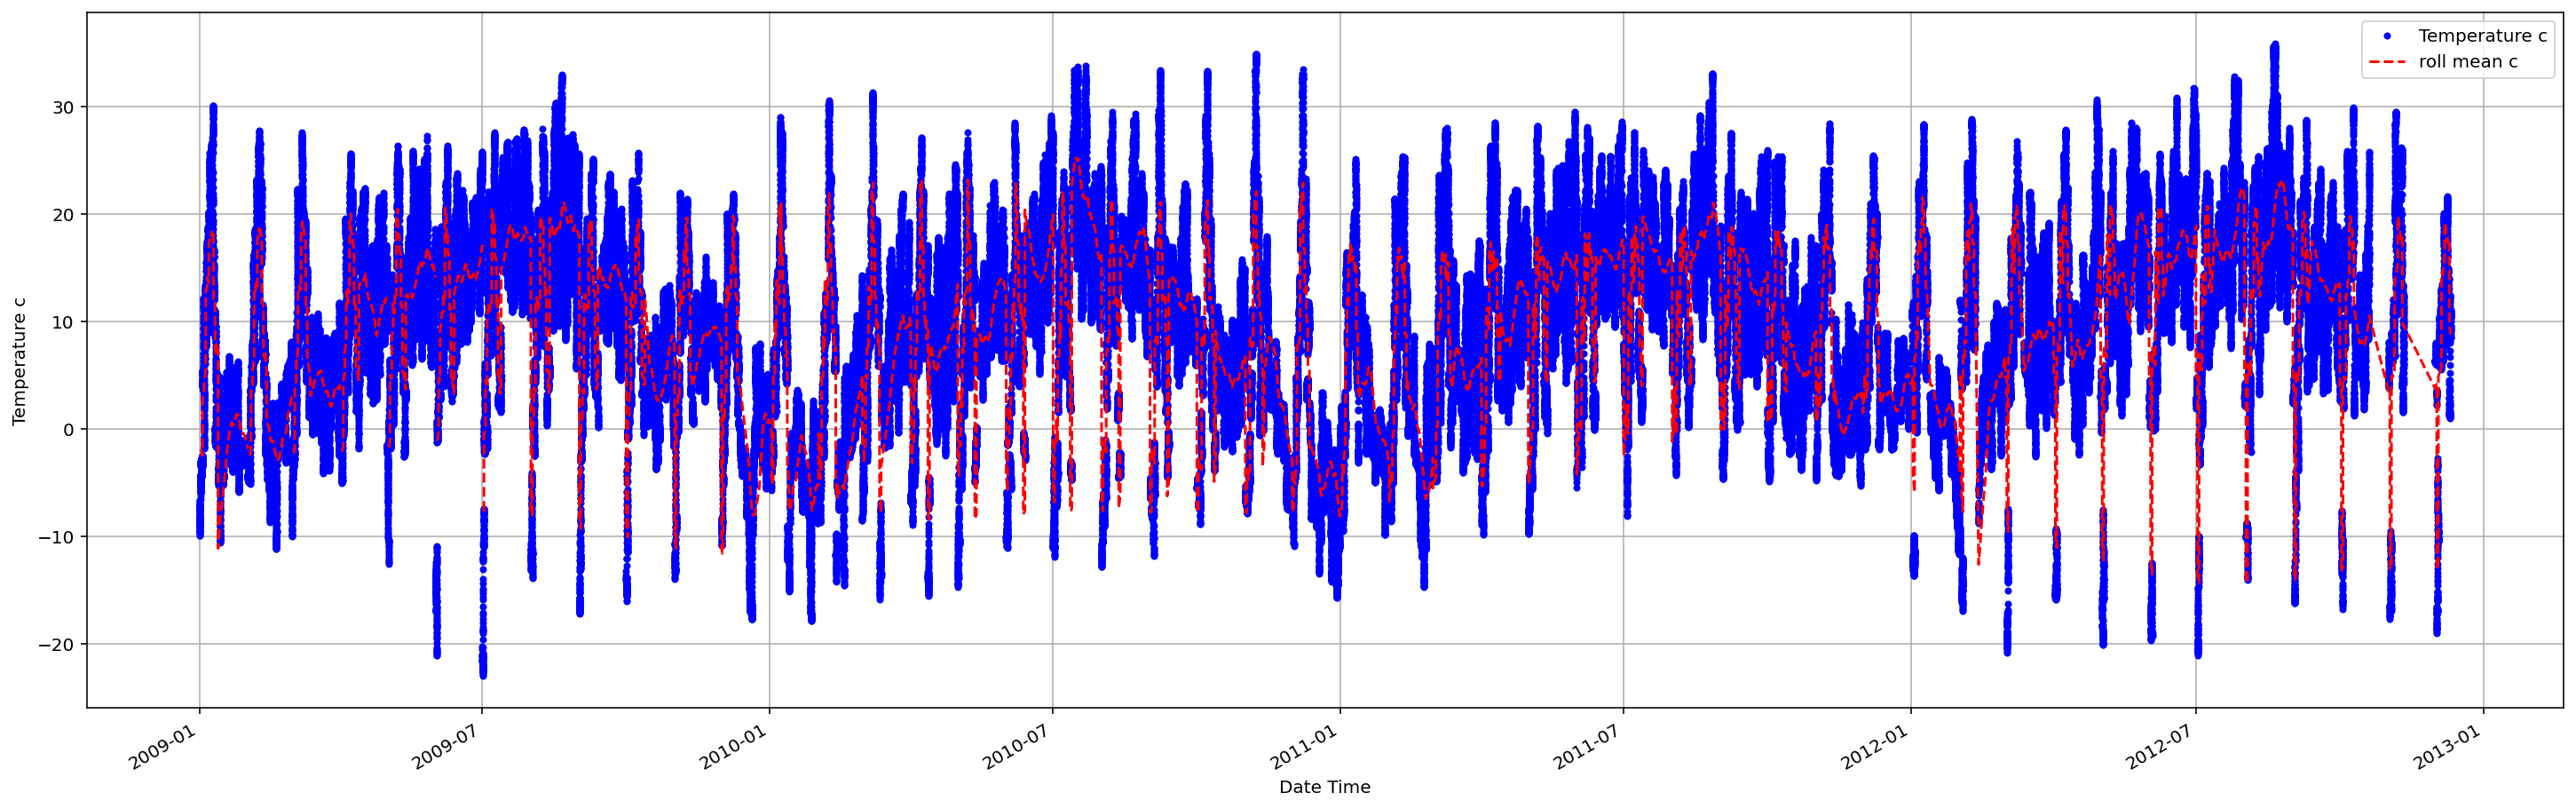

In [12]:
sub_df = df['T (degC)'][0:200_000]

sub_df.plot(kind='line', style='.',
                    figsize=(25,8), 
                    grid=True, label='Temperature c',
                    ylabel="Temperature c",
                    c='b',
                    )

rolmean = pd.Series(sub_df).rolling(window=1000).mean()
rolmean.plot(kind='line', style='--',
                    #figsize=(12,8), 
                    grid=True, label='roll mean c',
                    ylabel="Temperature c",
                    c='r',
                    )
plt.legend()
plt.show()

I choose 100k rows of data and it is enough to see the temperature periodic behavior.

In [369]:
train_df = df['T (degC)'][0:300_000]
# train_df.plot()

In [21]:
type(train_df)
train_df_np = np.array(train_df)

In [22]:
train_df_np

array([-8.02, -8.41, -8.51, ...,  0.95,  1.1 ,  1.13])

In [259]:
x_np = np.arange(0, 300_000, dtype=int)
x_np

array([     0,      1,      2, ..., 299997, 299998, 299999])

In [260]:
from tqdm import tqdm

In [261]:
# source https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/#
import numpy as np

def de(fobj, bounds, mut=0.8, crossp=0.7, popsize=30, its=1000):
    dimensions = len(bounds)
    pop = np.random.rand(popsize, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff
    fitness = np.asarray([fobj(ind) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx]
    for i in tqdm(range(its)):
#         print(i)
        for j in range(popsize):
            idxs = [idx for idx in range(popsize) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace = False)]
            mutant = np.clip(a + mut * (b - c), 0, 1)
            cross_points = np.random.rand(dimensions) < crossp
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = fobj(trial_denorm)
            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
        yield best, fitness[best_idx]

In [545]:
def fmodel(x, w):

    return w[0] * np.sin(np.radians((x+w[1])/w[2])) + w[3]

In [578]:
def obj(w):
    y_pred = fmodel(x, w)
    
    return sum((abs(y - y_pred)/len(y)))
#     return np.sqrt(sum((y - y_pred)**2) / len(y))

In [579]:
result = list(de(obj, [(-100,100)]*4, its=10))

100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.00it/s]


In [580]:
result

[(array([  8.71141277, -33.12216781, -72.4760919 ,   4.84480081]),
  12.730832547887703),
 (array([  8.71141277, -33.12216781, -72.4760919 ,   4.84480081]),
  12.730832547887703),
 (array([  8.71141277, -33.12216781, -72.4760919 ,   4.84480081]),
  12.730832547887703),
 (array([  8.71141277, -33.12216781, -72.4760919 ,   4.84480081]),
  12.730832547887703),
 (array([  5.95957464, 100.        , -23.15089221,   1.76181797]),
  12.279884931156559),
 (array([  5.95957464, 100.        , -23.15089221,   1.76181797]),
  12.279884931156559),
 (array([ -7.20973253, -33.12216781, -51.78410199,   2.47869293]),
  12.063976107202219),
 (array([ -7.20973253, -33.12216781, -51.78410199,   2.47869293]),
  12.063976107202219),
 (array([ -7.20973253, -33.12216781, -51.78410199,   2.47869293]),
  12.063976107202219),
 (array([ -7.20973253, -33.12216781, -51.78410199,   2.47869293]),
  12.063976107202219)]

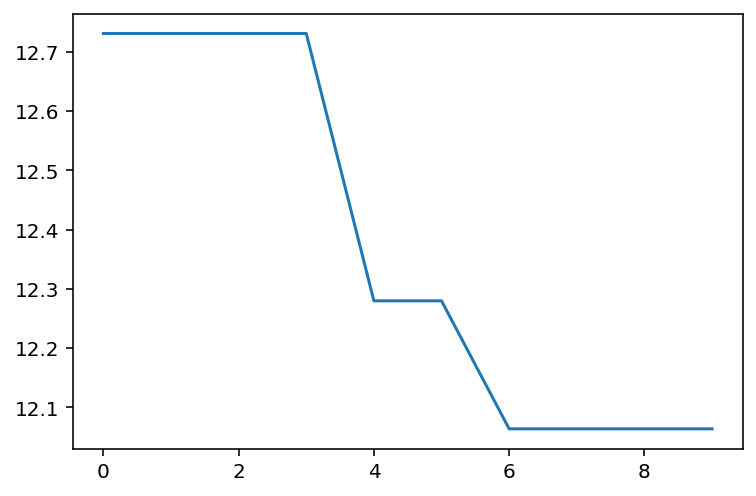

In [581]:
evol = []
for i in range(10):
    evol.append(result[i][1])
plt.plot(evol)

In [582]:
result[-1]

(array([ -7.20973253, -33.12216781, -51.78410199,   2.47869293]),
 12.063976107202219)

In [583]:
a,b,c,d = np.round(result[-1][0],6)

In [584]:
# plt.scatter(train_df,fmodel(x, [ -0.11, -10.97,   8.71]))

In [585]:
# plt.plot(fmodel(x, [ 2, 5,   3]))

In [586]:
def fmodel2(x, w):

    return w[0] * np.sin(np.radians((x-w[1])/w[2])) + w[3]

In [587]:
a,b,c,d

(-7.209733, -33.122168, -51.784102, 2.478693)

In [588]:
w = [a,b,c,d]
obj(w)

12.063976181743865

In [589]:
w = [20.010624, 20000, 140, 10]
obj(w)

19.139397041932135

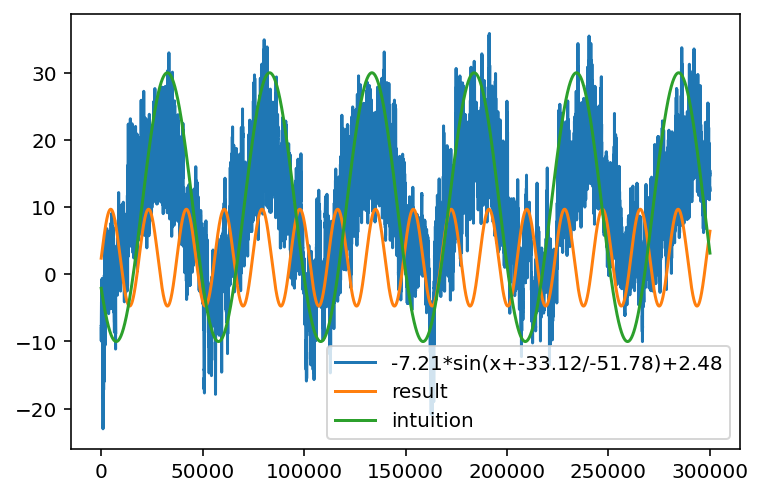

In [590]:
# plt.scatter(x_np, train_df_np)
a,b,c,d = np.round(result[-1][0],2)

plt.plot(x_np, train_df, label=f'{a}*sin(x+{b}/{c})+{d}')
# plt.plot(x, fmodel(x, [a, b, c]), label='result')
plt.plot(x_np, fmodel(x_np, [a,b,c,d]), label='result')
plt.plot(x_np, fmodel2(x_np, [20.010624, 20000, 140, 10]), label='intuition')

plt.legend()

In [ ]:
plt.scatter(x, y)
a,b,c = np.round(result[-1][0],2)

plt.plot(x, train_df, label=f'{a}*sin(x/{b})+{c}')
# plt.plot(x, fmodel(x, [a, b, c]), label='result')
plt.plot(x, fmodel(x, [a,b,c]), label='result')

plt.legend()